In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from numpy import random


import matplotlib
import matplotlib.animation as animation

from IPython.display import HTML

In [149]:
def make_initial_grid(n, prop_c_init, rand_seed, special = False):
    if special == False:
        # n*n matrix randomly 1 (C) or 0 (D)
        if rand_seed:
            random.seed(rand_seed)
        grid_strat = np.random.choice([0, 1], size=(n,n), p=[1 - prop_c_init, prop_c_init])
    else:
        grid_strat = np.ones((n, n), dtype = np.int8)
        grid_strat[round(n/2),round(n/2)] = 0

    return grid_strat

In [26]:
def play_game(player_1, player_2, t, r, p, s):
    '''
    1 (C) or 0 (D)
    both defect, both get p
    one player C one player D, D gets t
    one player C one player D, C gets s
    both players C, they both get r   
    '''
    if ((player_1 == 0) & (player_2 == 0)):
        payoff_player_1 = p
    elif ((player_1 == 0) & (player_2 == 1)):
        payoff_player_1 = t
    elif ((player_1 == 1) & (player_2 == 0)):
        payoff_player_1 = s 
    else:
        payoff_player_1 = r

    return payoff_player_1

In [4]:
def get_neighbour_strategies(grid_strat):
    
    down_neighbour = np.roll(grid_strat, -1, axis=0) # down
    up_neighbour = np.roll(grid_strat, 1, axis=0) # up
    left_neighbour = np.roll(grid_strat, -1, axis=1) # left
    right_neighbour = np.roll(grid_strat, 1, axis=1) # right
    
    return down_neighbour, up_neighbour, left_neighbour, right_neighbour

In [27]:
def get_cell_payoff(grid_strat,
                    down_neighbour,
                    up_neighbour,
                    left_neighbour,
                    right_neighbour,
                    row, col, t, r, p, s):
    
    payoff_down_cell = play_game(grid_strat[row,col], down_neighbour[row,col], t, r, p, s)
    payoff_up_cell = play_game(grid_strat[row,col], up_neighbour[row,col], t, r, p, s)
    payoff_left_cell = play_game(grid_strat[row,col], left_neighbour[row,col], t, r, p, s)
    payoff_right_cell = play_game(grid_strat[row,col], right_neighbour[row,col], t, r, p, s)

    payoff = payoff_down_cell + payoff_up_cell + payoff_left_cell + payoff_right_cell

    return payoff

In [6]:
def get_neighbour_payoffs(grid_payoff):
    
    down_neighbour_payoff = np.roll(grid_payoff, -1, axis=0) # down
    up_neighbour_payoff = np.roll(grid_payoff, 1, axis=0) # up
    left_neighbour_payoff = np.roll(grid_payoff, -1, axis=1) # left
    right_neighbour_payoff = np.roll(grid_payoff, 1, axis=1) # right
    
    return down_neighbour_payoff, up_neighbour_payoff, left_neighbour_payoff, right_neighbour_payoff


In [7]:
def get_strategy_change_code(old_strat, new_strat):
    '''
    0 = stayed as D 
    1 = stayed as C 
    2 = changed from D to C
    3 = changed from C to D
    '''
    if ((old_strat == 0) & (new_strat == 0)):
        change_code = 0
    elif ((old_strat == 0) & (new_strat == 1)):
        change_code = 2
    elif ((old_strat == 1) & (new_strat == 0)):
        change_code = 3 
    else:
        change_code = 1
    return change_code

In [31]:
def one_iteration(grid_strat, n, grid_payoff, grid_colours, t, r, p, s):
    
    # Get the neighbour's strategies:

    (down_neighbour,
     up_neighbour,
     left_neighbour,
     right_neighbour) = get_neighbour_strategies(grid_strat)

    # Get every cell's payoff:

    for row in range(0,n):
        for col in range(0,n):
            grid_payoff[row, col] = get_cell_payoff(grid_strat,
                                                    down_neighbour,
                                                    up_neighbour,
                                                    left_neighbour,
                                                    right_neighbour,
                                                    row, col, t, r, p, s)

    # Get the neighbour's payoffs:

    (down_neighbour_payoff,
     up_neighbour_payoff,
     left_neighbour_payoff,
     right_neighbour_payoff) = get_neighbour_payoffs(grid_payoff)


    # Consider your neighbours and change if they do better

    for row in range(0,n):
        for col in range(0,n):
            
            # Get previous strategy
            old_strat = grid_strat[row, col]

            # All the surrounding payoffs and your own
            b = np.array([grid_payoff[row, col],
                          right_neighbour_payoff[row,col], left_neighbour_payoff[row,col],
                          up_neighbour_payoff[row,col], down_neighbour_payoff[row,col]])

            # Get the index of the highest
            best_index = np.random.choice(np.flatnonzero(b == b.max())) # if the same pick one randomly
            
            # Update to the strategy of this 'best' cell
            grid_strat[row, col] = [grid_strat[row, col],
                          right_neighbour[row,col], left_neighbour[row,col],
                          up_neighbour[row,col], down_neighbour[row,col]][best_index]
            
            # Get colour matrix
            grid_colours[row, col] = get_strategy_change_code(old_strat, grid_strat[row, col])
    
    return grid_strat, grid_colours

In [146]:
def run_coopsim(payoffs = [1.7, 1, 0, 0],
                n = 100,
                prop_c_init = 0.5,
                rand_seed = 10,
                num_iterations = 100, special_init = False):
    '''
    t : one player C one player D, D gets t
    r : both players C, they both get r
    p : both defect, both get p
    s : one player C one player D, C gets s
    
    n : Length of grid
    
    prop_c_init : Initial proportion of cooperators
    
    rand_seed : Seed used
    
    num_iterations : Number of iterations
    
    special_init : if true then starts with one coop in the middle
    
    '''
    
    # Payoffs
    t = payoffs[0]
    r = payoffs[1]
    p = payoffs[2]
    s = payoffs[3]
    
    
    # ---------
    # Make data

    grid_strat = make_initial_grid(n, prop_c_init, rand_seed, special_init)

    grid_payoff = np.empty((n,n,))
    grid_payoff[:] = np.nan

    grid_colours = np.empty((n,n,))
    grid_colours[:] = np.nan

    grid_strat_all = []
    grid_colours_all =[]

    for _ in range(0, num_iterations):

        grid_strat, grid_colours = one_iteration(grid_strat, n, grid_payoff, grid_colours, t, r, p, s)

        grid_strat_all.append(grid_strat.copy())
        grid_colours_all.append(grid_colours.copy())
        
    return grid_strat_all, grid_colours_all
    

In [122]:
def animate(i):
    #fig, ax = plt.subplots()
    ax.imshow(grid_colours_all[i])
    return fig, ax

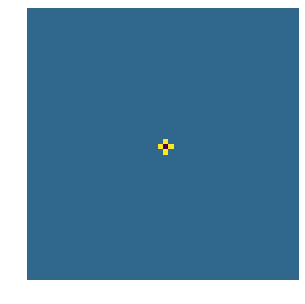

In [155]:
# ---------
# Parameters
payoffs = [1.7, 1, 0.3, 0]

#t : one player C one player D, D gets t
#r : both players C, they both get r
#p : both defect, both get p
#s : one player C one player D, C gets s
        
n = 50
prop_c_init = 0.5
rand_seed = None
num_iterations = 100
plot_size_n = 5 # Size of video
num_frames = num_iterations # Number of frames in the video 
special_init = True
# ---------
# Get info

grid_strat_all, grid_colours_all = run_coopsim(payoffs,
                n,
                prop_c_init,
                rand_seed, num_iterations,special_init)


# ---------
# Make video

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(figsize=(plot_size_n, plot_size_n))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, frames=num_frames, blit=False)

HTML(anim.to_html5_video())